# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strengths
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [6]:
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'comp411/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **comp411/classifiers/softmax.py**. 


In [8]:
# First implement the naive softmax loss function with nested loops.
# Open the file comp411/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from comp411.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.351693
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ Since we randomly initiate weight, it is similar to randomly choose one of the 10 group. As a result, the loss will be eqaul to -log(probability of the correct guess)=-log(0.1)


In [13]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from tkinter.filedialog import SaveFileDialog
from comp411.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)
 
# similar to SVM case, do another gradient check with regularizations
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1, 5e-4)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1, 5e-4)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.790979 analytic: 0.790979, relative error: 2.661580e-08
numerical: -0.137682 analytic: -0.137683, relative error: 2.944916e-07
numerical: -3.436647 analytic: -3.436647, relative error: 1.550919e-08
numerical: 1.887141 analytic: 1.887141, relative error: 9.376245e-09
numerical: 1.685151 analytic: 1.685151, relative error: 4.566323e-08
numerical: -0.105471 analytic: -0.105471, relative error: 4.107090e-07
numerical: 0.707347 analytic: 0.707347, relative error: 8.787636e-08
numerical: -1.634466 analytic: -1.634466, relative error: 2.270927e-08
numerical: -0.126700 analytic: -0.126700, relative error: 2.161791e-07
numerical: 2.340018 analytic: 2.340018, relative error: 7.458612e-09
numerical: -2.621550 analytic: -2.622050, relative error: 9.535526e-05
numerical: 1.936918 analytic: 1.937418, relative error: 1.290536e-04
numerical: -2.153765 analytic: -2.154265, relative error: 1.160687e-04
numerical: -0.782997 analytic: -0.782997, relative error: 4.828738e-08
numerical: -1.2541

In [15]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.351694e+00 computed in 0.229553s
vectorized loss: 2.351694e+00 computed in 0.002885s
Loss difference: 0.000000
Gradient difference: 0.000000


In [28]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from comp411.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be similar to the validation that you did for the SVM; save      #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths_l2 = [2.5e4,2e2]
regularization_strengths_l1 = [0, 2.5e2,1e-5,1e-2]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for l2 in  regularization_strengths_l2:
        for l1 in regularization_strengths_l1:
  
            classifier = Softmax()
            classifier.train(X_train, y_train, learning_rate=lr, reg=l2,reg_l1=l1,num_iters=1500, verbose=False)
                      
            y_val_pred = classifier.predict(X_val)
            y_train_pred = classifier.predict(X_train)
            val_acc=np.mean(y_val == y_val_pred)
            train_acc=np.mean(y_train == y_train_pred)
            results[(lr,l2,l1)]=(train_acc,val_acc)
            if (best_val<val_acc):
                best_val=val_acc
                best_softmax=classifier


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, rg_l2, rg_l1 in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rg_l2,rg_l1)]
    print('lr %e rg_l2 %e rg_l1 %e train accuracy: %f val accuracy: %f' % (
                lr, rg_l2, rg_l1, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 rg_l2 2.000000e+02 rg_l1 0.000000e+00 train accuracy: 0.252265 val accuracy: 0.257000
lr 1.000000e-07 rg_l2 2.000000e+02 rg_l1 1.000000e-05 train accuracy: 0.250061 val accuracy: 0.249000
lr 1.000000e-07 rg_l2 2.000000e+02 rg_l1 1.000000e-02 train accuracy: 0.251082 val accuracy: 0.252000
lr 1.000000e-07 rg_l2 2.000000e+02 rg_l1 2.500000e+02 train accuracy: 0.152551 val accuracy: 0.143000
lr 1.000000e-07 rg_l2 2.500000e+04 rg_l1 0.000000e+00 train accuracy: 0.329673 val accuracy: 0.348000
lr 1.000000e-07 rg_l2 2.500000e+04 rg_l1 1.000000e-05 train accuracy: 0.326592 val accuracy: 0.343000
lr 1.000000e-07 rg_l2 2.500000e+04 rg_l1 1.000000e-02 train accuracy: 0.326653 val accuracy: 0.350000
lr 1.000000e-07 rg_l2 2.500000e+04 rg_l1 2.500000e+02 train accuracy: 0.233408 val accuracy: 0.225000
lr 5.000000e-07 rg_l2 2.000000e+02 rg_l1 0.000000e+00 train accuracy: 0.336796 val accuracy: 0.354000
lr 5.000000e-07 rg_l2 2.000000e+02 rg_l1 1.000000e-05 train accuracy: 0.336245 val

In [29]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.340000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ The statement is correct.


$\color{blue}{\textit Your Explanation:}$

In the SVM it is possible, since we can add instance such that the score of the highest guess is at least one value greater than the score of the others classes, in this case the training data does not effect the overall loss.

We cannot add instance to traing data in the Softmax classifier and expect no change in the loss value. The addedd loss value is -log(p). we know that 0<p<1, as a result -log(p)>0, and since this is a positive value, it will increase the loss function.


**Inline Question 3** 

Comment on the effects of unifying L1 and L2 losses while using Elastic Net Regularization Loss? Did L2 loss achieve better when used alone or not?

$\color{blue}{\textit Your Comment:}$
The point of using Regularizer is to avoid overfitting by finidng more simpler awnser. L2 harshly penalize large differences, and L1 acts as a feature selector, furthermore,  ElasticNet constrainit the space of the weight that our algorithm is trying to explore, which prevents from overfitting. 
Based on the hyperparameter search results, it seems like L2 loss achieve better accuracy than using elastic Net regularization, however, the reason behind this observation is not clear to me.

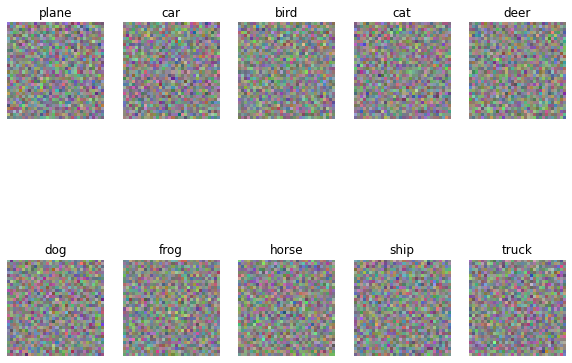

In [31]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])